In [34]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches

## Calculate random Euler angles

In [35]:
# return n "random" Euler angles in radians
def random(n):
    return 2*np.pi*np.random.rand(n,3)

In [36]:
ea = random(50)
print(ea[:10,])

[[3.27043908 4.1437036  1.30114414]
 [5.99946352 5.24952002 3.8137957 ]
 [0.69530334 1.60260591 4.88620123]
 [5.96993878 4.7885503  6.15537107]
 [3.08680283 4.37112279 3.38530824]
 [3.23629593 2.95111564 3.6226394 ]
 [5.19127328 2.15335747 1.62326932]
 [5.96762923 6.03568655 2.47414405]
 [6.02108579 6.12318138 1.66673449]
 [4.71313403 5.74672143 4.48046418]]


## Convert Euler angles into rotation matrices

In [37]:
def trans2(a):
    s=list(range(len(a.shape)))
    return np.transpose(a,s[:-2]+s[-1:-3:-1])
# return rotation matrices from Euler angles ea
def matrices(ea):
    def trans1(a):
        s=list(range(len(a.shape)))
        return np.transpose(a,s[2:]+s[:2])
    def rot_z(a):
        c,s=np.cos(a),np.sin(a)
        u=1.*(a==a); z=0.*u
        return trans1(np.array([[c,-s,z],[s,c,z],[z,z,u]]))
    def rot_x(a):
        c,s=np.cos(a),np.sin(a)
        u=1.*(a==a); z=0.*u
        return trans1(np.array([[u,z,z],[z,c,-s],[z,s,c]]))
    phi1,Phi,phi2=np.transpose(ea)
    r=rot_z(phi2)@rot_x(Phi)@rot_z(phi1)
    return trans2(r)

In [38]:
rot = matrices(ea)
print(rot[:10,])

[[[-3.30882693e-01 -9.37440600e-01  1.08267095e-01]
  [-4.80532511e-01  2.66118825e-01  8.35625081e-01]
  [-8.12160790e-01  2.24468019e-01 -5.38524799e-01]]

 [[-8.40362256e-01 -4.85742560e-01  2.40510797e-01]
  [ 8.68539542e-02 -5.58669175e-01 -8.24830373e-01]
  [ 5.35021185e-01 -6.72266999e-01  5.11673151e-01]]

 [[ 1.12725003e-01 -7.59813311e-01  6.40294312e-01]
  [-1.34840725e-01  6.26742606e-01  7.67470967e-01]
  [-9.84434382e-01 -1.72850916e-01 -3.18042155e-02]]

 [[ 9.40589362e-01 -1.44518846e-01  3.07255521e-01]
  [ 3.14861878e-01  3.25160321e-02 -9.48580363e-01]
  [ 1.27097009e-01  9.88967649e-01  7.60877090e-02]]

 [[ 9.64569117e-01  2.58734244e-01 -5.16043535e-02]
  [ 1.33784668e-01 -3.11087983e-01  9.40917600e-01]
  [ 2.27394110e-01 -9.14483930e-01 -3.34680536e-01]]

 [[ 9.25501703e-01  3.78320070e-01 -1.79031274e-02]
  [ 3.68472912e-01 -9.10331482e-01 -1.88478925e-01]
  [-8.76031408e-02  1.67840749e-01 -9.81914035e-01]]

 [[-5.11772043e-01  4.34545484e-01 -7.41120502e-01]


## Plot pole figures

In [39]:
# plot p pole figure from rotation matrices rot
def plot(rot, p, *args, **kvargs):
    def circle1(size):
        plt.figure(figsize=(size,size))
        ax = plt.gca()
        # Make the circle patch and add to the figure
        circle = plt.Circle((0, 0), 1, color='#777', fill=None)
        ax.add_patch(circle)   
        # Make it a perfect circle by making it a perfect square box
        ax.set_aspect('equal', adjustable='box')
        # Set axis so it's visible 
        plt.xlim([-1.01,1.01])  
        plt.ylim([-1.01,1.01])
        ax.spines['left'].set_position('center')
        ax.spines['bottom'].set_position('center')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.set_xticks([])
        ax.set_yticks([])
    def stereo_n(n,size=3,color='r'):
        n = (np.abs(n[:,2:])<1)*n
        xy = n[:,:2]/(1-n[:,2:])
        yx = -n[:,:2]/(1+n[:,2:])
        m = (xy*xy).sum(axis=1)
        xy = np.where(np.transpose([m,m])<=1,xy,yx)
        circle1(size)
        if isinstance(color, np.ndarray):
            cmap = plt.cm.rainbow
            norm = matplotlib.colors.Normalize(vmin=np.min(color), vmax=np.max(color))
            color = cmap(norm(color))
        plt.scatter(xy[:,0], xy[:,1], color=color, marker='.')
        plt.show()
        plt.close()
    p = np.array(p)
    n = rot@(p/(p*p).sum()**0.5)
    stereo_n(n,*args,**kvargs)

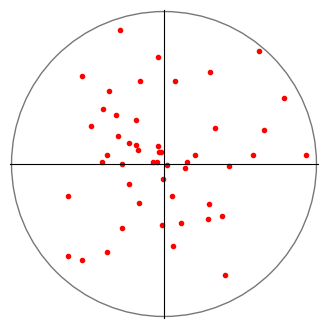

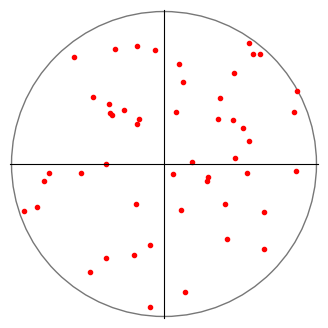

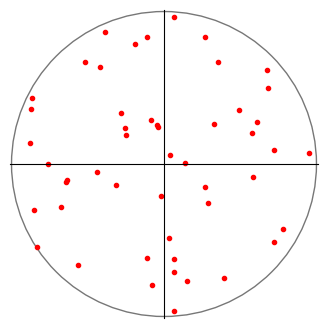

In [40]:
plot(rot, [0,0,1], size=4)
plot(rot, [1,0,0], size=4)
plot(rot, [1,1,0], size=4)

## Calculate misorientations

In [41]:
def norm(v):
    n=(v*v).sum(axis=-1)
    n=np.where(n==0,1,n)
    return np.transpose(np.transpose(v)/n**0.5)
# returns disorientation angle in radians and axis
def misorientations(csym,r):
    def ang(r):
        return np.arccos((np.trace(r,axis1=-2,axis2=-1)-1)/2.)
    def axis(r):
        s=list(range(len(r.shape)))
        r=np.transpose(r-trans2(r),s[-2:]+s[:-2])
        return norm(np.transpose([r[1,2],r[2,0],r[0,1]]))
    d=[]
    for ri,rj in itertools.combinations(r,2):
        d.append(ri@trans2(rj))
    p=[]
    for s,di in itertools.product(csym,d):
        p.append(s@di)
    p=np.array(p).reshape(len(csym),len(d),3,3)
    a=ang(p)
    m=a.argmin(axis=0)
    i=(m,range(len(m)))
    return a[i],axis(p[i])

In [42]:
def Rmiller(hkl,uvw):
    assert(0==np.dot(hkl,uvw)) # must be perpendicular
    n,d=norm(np.array(hkl)),norm(np.array(uvw))
    c=norm(np.cross(n,d))
    return np.array([d,c,n])

In [43]:
cubic=[
    # face 001 perpendicular to 001
    Rmiller([0,0,1],[1,0,0]),Rmiller([0,0,1],[0,1,0]),Rmiller([0,0,1],[-1,0,0]),Rmiller([0,0,1],[0,-1,0]),
    # face 010 perpendicular to 001
    Rmiller([0,1,0],[1,0,0]),Rmiller([0,1,0],[0,0,1]),Rmiller([0,1,0],[-1,0,0]),Rmiller([0,1,0],[0,0,-1]),
    # face 100 perpendicular to 001
    Rmiller([1,0,0],[0,0,1]),Rmiller([1,0,0],[0,1,0]),Rmiller([1,0,0],[0,0,-1]),Rmiller([1,0,0],[0,-1,0]),
    # face -001 perpendicular to 001
    Rmiller([0,0,-1],[1,0,0]),Rmiller([0,0,-1],[0,1,0]),Rmiller([0,0,-1],[-1,0,0]),Rmiller([0,0,-1],[0,-1,0]),
    # face -010 perpendicular to 001
    Rmiller([0,-1,0],[1,0,0]),Rmiller([0,-1,0],[0,0,1]),Rmiller([0,-1,0],[-1,0,0]),Rmiller([0,-1,0],[0,0,-1]),
    # face -100 perpendicular to 001
    Rmiller([-1,0,0],[0,0,1]),Rmiller([-1,0,0],[0,1,0]),Rmiller([-1,0,0],[0,0,-1]),Rmiller([-1,0,0],[0,-1,0])
]
ang,axis = misorientations(cubic, rot)

In [44]:
print((180*ang[:10])/np.pi)

[41.40583826 45.77114558 21.71782508 57.2313563  56.56783218 35.35815041
 54.06134576 27.01604447 28.17424736 42.08704487]


## Jonas' solution

In [45]:
import numpy as np
#calculate random Euler angles
def random():
    Alpha= np.random.uniform(0,2*np.pi)
    Beta = np.random.uniform(0,np.pi)
    Gamma=np.random.uniform(0,2*np.pi)
    return (Alpha,Beta,Gamma)
ea=random()
print(ea)
 
def matrices(ea):
    # ea are the Euler angles as a numpy array of shape (3)
    # return orientation matrix (numpy array of shape (3,3))
    Alpha,Beta,Gamma=ea
    rot_x=np.array([[1,0,0],[0,np.cos(Beta),-np.sin(Beta)],[0,np.cos(Beta),np.sin(Beta)]])
    rot_z_1=np.array([[np.cos(Alpha),-np.sin(Alpha),0],[np.sin(Alpha),np.cos(Alpha),0],[0,0,1]])
    rot_z_2=np.array([[np.cos(Gamma),-np.sin(Gamma),0],[np.sin(Gamma),np.cos(Gamma),0],[0,0,1]])
 
   
    r=rot_z_2@rot_x@rot_z_1
    return np.transpose(r)
r=matrices(ea)
print(r)

(5.520085694351216, 2.71109664821943, 3.2315861704890256)
[[-0.66332376 -0.69051075  0.62810218]
 [-0.74739208  0.59198332 -0.65675744]
 [-0.03750557  0.41563283  0.4173216 ]]
